In [1]:
from lxml import objectify
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K 
from keras import backend as K
from keras.metrics import Accuracy, Precision, Recall
import seaborn as sns

# READING THE DATA

In [2]:
cars = pd.read_csv('DATA_CARS.csv') #bring in file names and hand typed info
#print(cars)

file = cars.drop(['cyl','dis','comp', 'bore'], axis = 1 ) #names of files
allx2 = cars.drop(['File','dis','comp', 'bore'], axis = 1 )
allx3 = cars.drop(['File','cyl','comp', 'bore'], axis = 1 )
allx4 = cars.drop(['File','cyl','dis', 'bore'], axis = 1 )
allx5 = cars.drop(['File','cyl','dis','comp',], axis = 1 )

"""print(x2)
print(file)
print(type(file))"""

names = file.values.tolist()
#print(names)
#print('\n')
#print('# of files',len(names))

out = []

CSV_id = 0

for name in range(len(names)):
    #print(names[name])
    floater = names[name] # to remove list inside list
    #print('floater = ',floater[0])
    xml = objectify.parse(floater[0]) # parse msq or xml file 
    root = xml.getroot()    # GET FILE HEADER OR FIRST XML ELEMENT?
    rows = root.findall('.//constant') # STEPS INWARD ON ELEMENT TREE TO 'CONSTANT'

    data_attrib = [] # OPEN LIST TO STORE INFO FOR PULLIN IDX LOCATION
    for constant in root.iter('constant'):
        """print(constant.attrib)"""
        """ print(constant.items())"""
        data2 = constant.items() 

        
        #REPLACES ALL UNIT DECREPANCY WITH kPa 
        if data2 == [('cols', '1'), ('digits', '1'), ('name', 'smap_table1'), ('rows', '12'), ('units', '%')]: 
            data2 = [('cols', '1'), ('digits', '1'), ('name', 'smap_table1'), ('rows', '12'), ('units', 'kPa')]
        elif data2 == [('cols', '1'), ('digits', '1'), ('name', 'smap_table1'), ('rows', '12'), ('units', '% TPS')]:
            data2 = [('cols', '1'), ('digits', '1'), ('name', 'smap_table1'), ('rows', '12'), ('units', 'kPa')]
        elif data2 == [('cols', '1'), ('digits', '1'), ('name', 'smap_table1'), ('rows', '12'), ('units', 'ITB')]:
            data2 = [('cols', '1'), ('digits', '1'), ('name', 'smap_table1'), ('rows', '12'), ('units', 'kPa')]
        

        data_attrib.append(data2) #ALL ATTRIB OF ELEMENTS 'CONSTANT' PLACED HERE WITH == IDX TO XML FILE
            
    """print(data_attrib)"""
    ID_T1 = data_attrib.index([('cols', '12'), ('digits', '1'), ('name', 'advanceTable1'), ('rows', '12'), ('units', 'deg')])
    
    ID_T1_X0 = (data_attrib.index([('cols', '1'), ('digits', '1'), ('name', 'smap_table1'), ('rows', '12'), ('units', 'kPa')]))
    ID_T1_X1 = (data_attrib.index([('cols', '1'), ('digits', '0'), ('name', 'srpm_table1'), ('rows', '12'), ('units', 'RPM')]))
    
    y = rows[ID_T1].pyval# advanceTable1 type:str
    x0 = rows[ID_T1_X0].pyval #smap_table1 
    x1 = rows[ID_T1_X1].pyval  #srpm_table1  
    
    ystr = StringIO(y) #reads txt like file object, str format ("0 1\n2 3")
    y_array = np.loadtxt(ystr) #array 12x12
    
    x0str = StringIO(x0) #reads txt like file object, str format ("0 1\n2 3")
    x0_12 = np.loadtxt(x0str) #array (1,12)
    x0_1 = np.reshape(x0_12, (12,1)) #changes shape to array 12,1
    x0_array = np.tile(x0_1,(1,12) ) #array 12,12
    
    
    x1str = StringIO(x1) #reads txt like file object, str format ("0 1\n2 3")
    x1_12 = np.loadtxt(x1str) #array (1,12)
    x1_array = np.tile(x1_12,(12,1) ) #array 12,12
    
    
    x2 = allx2.iloc[CSV_id].values #other x values shape(1,) 
    x2_array = np.tile(x2,(12,12) )
    
    x3 = allx3.iloc[CSV_id].values  #other x values shape(1,)
    x3_array = np.tile(x3,(12,12) )
    
    x4 = allx4.iloc[CSV_id].values  #other x values shape(1,)
    x4_array = np.tile(x4,(12,12) )
    
    x5 = allx5.iloc[CSV_id].values  #other x values shape(1,)
    x5_array = np.tile(x5,(12,12) )
    
    y_stack =np.concatenate(y_array) #reshapes (12,12) to (144,1)
    x0_stack =np.concatenate(x0_array)#reshapes (12,12) to (144,1)
    x1_stack =np.concatenate(x1_array)#reshapes (12,12) to (144,1)
    x2_stack =np.concatenate(x2_array)#reshapes (12,12) to (144,1)
    x3_stack =np.concatenate(x3_array)#reshapes (12,12) to (144,1)
    x4_stack =np.concatenate(x4_array)#reshapes (12,12) to (144,1)
    x5_stack =np.concatenate(x5_array)#reshapes (12,12) to (144,1)
    yx_stack =np.column_stack((y_stack, x0_stack, x1_stack, x2_stack, x3_stack, x4_stack, x5_stack ))
    
    #print('file = ', floater[0])
    
      
    out.append(yx_stack)
    
    CSV_id = CSV_id+1 #counter
    
print('\n')
outarray= np.array(out)
yx = np.concatenate(outarray) #reshapes (24,144,7) to (3456,7)

print('shape out =', yx.shape)
print('out =', yx[0])
print('\n')

df = pd.DataFrame(data=yx, columns=["y", "PER","RPM","CYL","DIS","COMP","BORE"])
print('df= \n',df)





shape out = (3744, 7)
out = [  9.8   20.1  701.     4.     2.5    9.5    3.94]


df= 
          y    PER     RPM  CYL  DIS  COMP  BORE
0      9.8   20.1   701.0  4.0  2.5   9.5  3.94
1     11.1   20.1   900.0  4.0  2.5   9.5  3.94
2     13.0   20.1  1200.0  4.0  2.5   9.5  3.94
3     14.9   20.1  1500.0  4.0  2.5   9.5  3.94
4     18.1   20.1  2000.0  4.0  2.5   9.5  3.94
...    ...    ...     ...  ...  ...   ...   ...
3739  33.0  101.0  4000.0  8.0  3.9   9.0  3.70
3740  33.4  101.0  4500.0  8.0  3.9   9.0  3.70
3741  34.3  101.0  5000.0  8.0  3.9   9.0  3.70
3742  35.0  101.0  5500.0  8.0  3.9   9.0  3.70
3743  35.9  101.0  6000.0  8.0  3.9   9.0  3.70

[3744 rows x 7 columns]


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '20.1'),
  Text(0, 1.5, '25.0'),
  Text(0, 2.5, '30.0'),
  Text(0, 3.5, '35.0'),
  Text(0, 4.5, '40.0'),
  Text(0, 5.5, '45.0'),
  Text(0, 6.5, '50.0'),
  Text(0, 7.5, '60.0'),
  Text(0, 8.5, '70.0'),
  Text(0, 9.5, '80.0'),
  Text(0, 10.5, '90.0'),
  Text(0, 11.5, '100.0')])

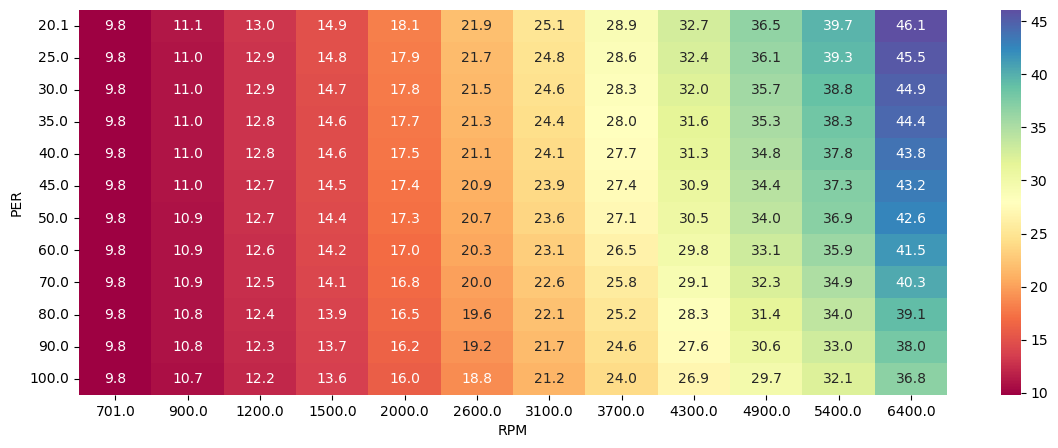

In [3]:
DF=df[0:144]#file 34.msq table
SA_table = DF.drop(["CYL","DIS","COMP","BORE"], axis=1)


pivot_SA_table = SA_table.pivot_table(index='PER', columns='RPM', values='y')


plt.figure(figsize=(14, 5))
ax1_pivot_SA_table = sns.heatmap(pivot_SA_table, annot=True, cmap="Spectral",fmt=".1f")
plt.yticks(rotation=0) 

we have our data!!!! only took forever

# UNDERSTANDING THE DATA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       3744 non-null   float64
 1   PER     3744 non-null   float64
 2   RPM     3744 non-null   float64
 3   CYL     3744 non-null   float64
 4   DIS     3744 non-null   float64
 5   COMP    3744 non-null   float64
 6   BORE    3744 non-null   float64
dtypes: float64(7)
memory usage: 204.9 KB


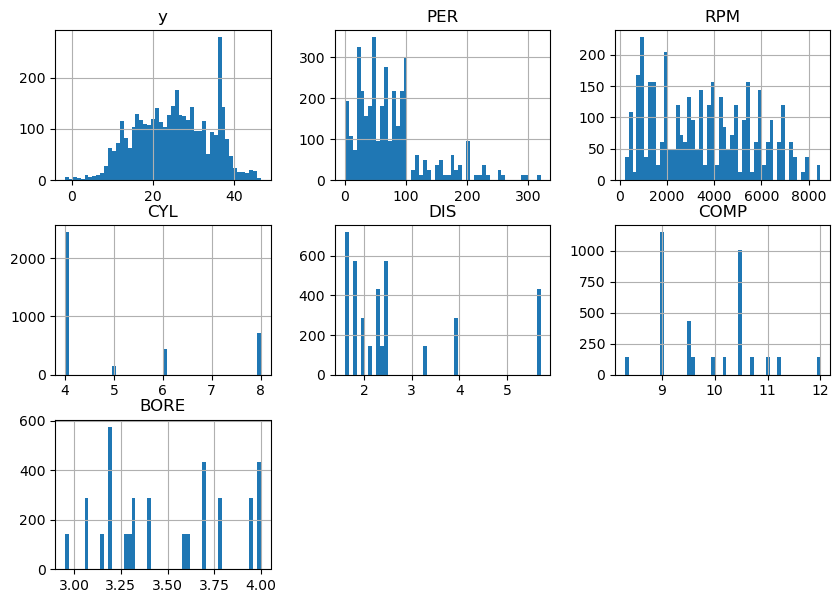

In [4]:
df.info()
#no missing data
#data very clean
df.hist(bins=50, figsize=(10,7))# show that data need to normalize, also shows a dimention problem with some x's
plt.show()

In [5]:
data_matrix= df.copy()
corr_matrix = data_matrix.corr()
corr_data = df.copy()
#print(corr_data.mode(), "\n") # shows most uses valus in data
#RPM 2000
#%100
idx_2000_RPM = corr_data.RPM[corr_data.RPM == 2000].index.tolist()
RPM_2000_data = df.loc[idx_2000_RPM] #all data with 2000rpm
#print(RPM_2000_data.size,"\n")
idx_100_per = corr_data.PER[corr_data.PER == 100].index.tolist()
per_100_data = df.loc[idx_100_per] #all data with 100%
RPM_corr_matrix = RPM_2000_data.corr()
#print(per_100_data.size,"\n") #larger so i will look in this data for RPM at 2000
per_corr_matrix = per_100_data.corr()
idx_2000and100 = per_100_data.RPM[per_100_data.RPM == 2000].index.tolist()
data_2000and100 = df.loc[idx_2000and100] #all data with 2000rpm and 100%
both_corr_matrix = data_2000and100.corr()


print("all_data", "\n")
print(corr_matrix["y"].sort_values(ascending=False), "\n")
print("RPM Lock data", "\n")
print(RPM_corr_matrix["y"].sort_values(ascending=False), "\n")
print("% Lock data", "\n")
print(per_corr_matrix["y"].sort_values(ascending=False), "\n")
print("both RPM and % lock data", "\n")
print(both_corr_matrix["y"].sort_values(ascending=False), "\n")

all_data 

y       1.000000
RPM     0.493035
CYL     0.300192
DIS     0.240412
BORE    0.077753
COMP   -0.099847
PER    -0.424386
Name: y, dtype: float64 

RPM Lock data 

y       1.000000
CYL     0.637858
DIS     0.467998
BORE   -0.103380
COMP   -0.265478
PER    -0.446206
RPM          NaN
Name: y, dtype: float64 

% Lock data 

y       1.000000
RPM     0.601469
CYL     0.304958
DIS     0.224978
BORE    0.046628
COMP   -0.325496
PER          NaN
Name: y, dtype: float64 

both RPM and % lock data 

y       1.000000
CYL     0.695936
DIS     0.489523
COMP   -0.048812
BORE   -0.228475
PER          NaN
RPM          NaN
Name: y, dtype: float64 



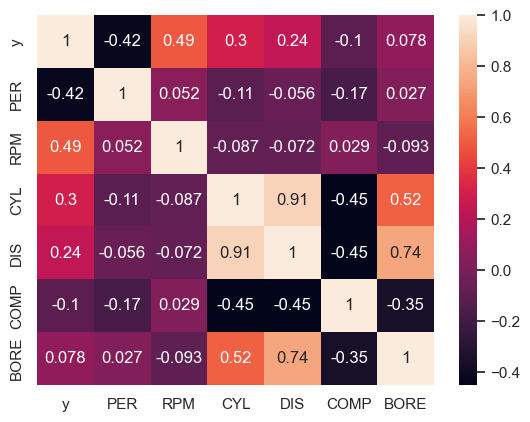

In [6]:
import seaborn as sns
"""iris = data_matrix.to_numpy()
cov_data = np.corrcoef(iris)
print(cov_data.shape)
print(cov_data[:10])"""

sns.set_theme()
ax = sns.heatmap(corr_matrix, annot=True,)


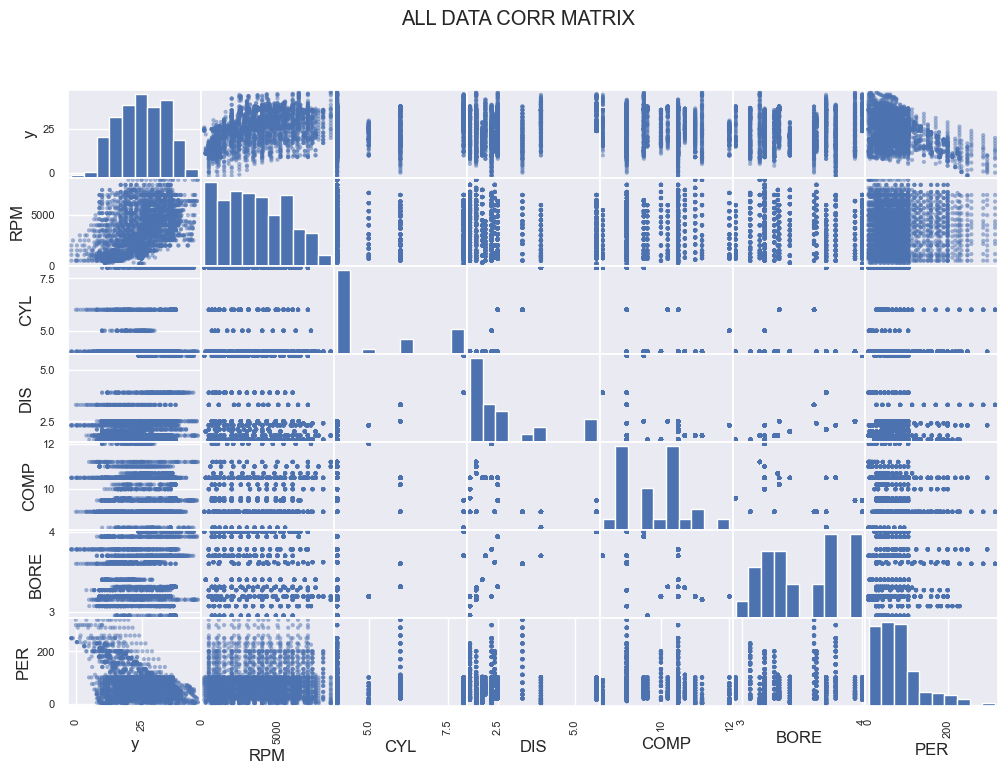

In [7]:
attributes = ["y", "RPM", "CYL","DIS","COMP","BORE", "PER"]
scatter_matrix(data_matrix[attributes], figsize=(12,8))
plt.suptitle('ALL DATA CORR MATRIX') 
plt.show()

Y and RPM matrix plots looks logarithmic,  y and % matrix plot looks like a decay

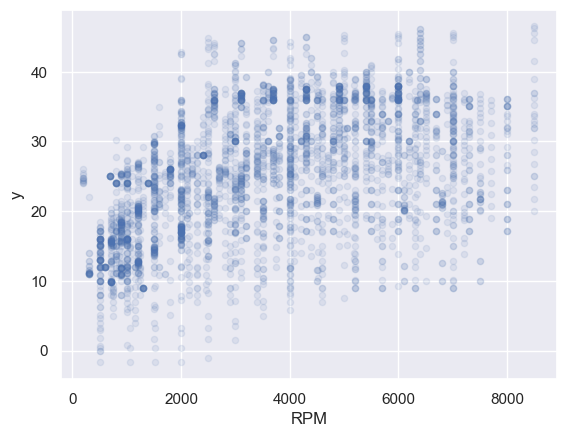

In [8]:
data_matrix.plot(kind="scatter", x="RPM", y="y", alpha=0.1)
plt.show()

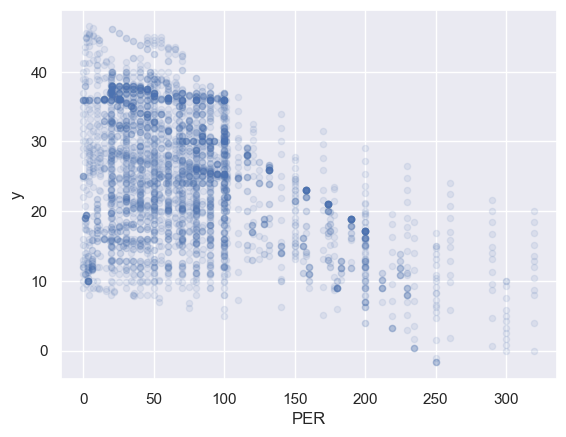

In [9]:
data_matrix.plot(kind="scatter", x="PER", y="y", alpha=0.1)
plt.show()

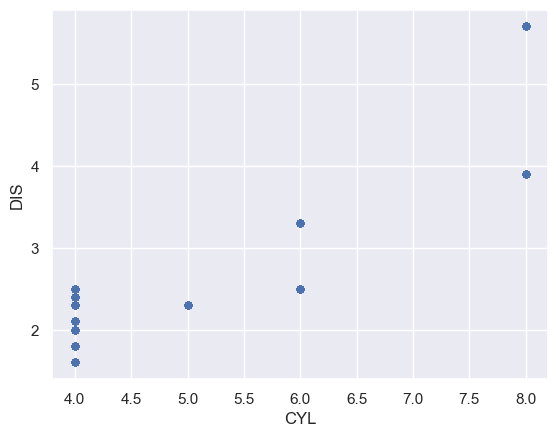

In [10]:
data_matrix.plot(kind="scatter", x="CYL", y="DIS", alpha=0.1)
plt.show()

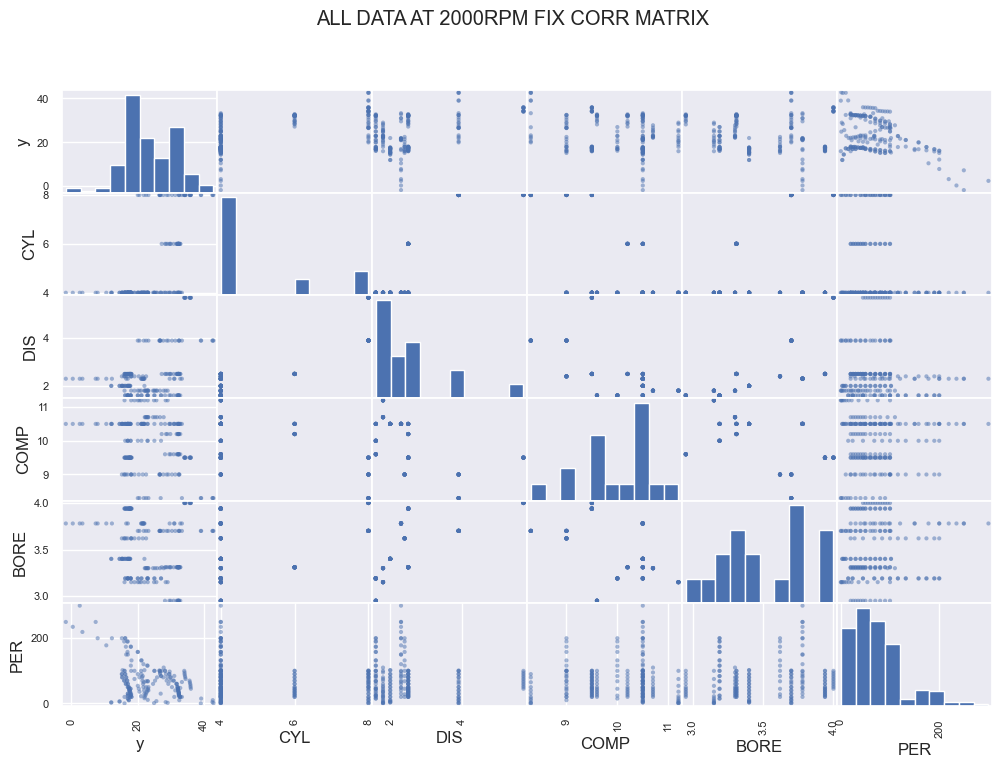

In [11]:
attributes = ["y", "CYL","DIS","COMP","BORE", "PER"]
scatter_matrix(RPM_2000_data[attributes], figsize=(12, 8))
plt.suptitle('ALL DATA AT 2000RPM FIX CORR MATRIX') 
plt.show()

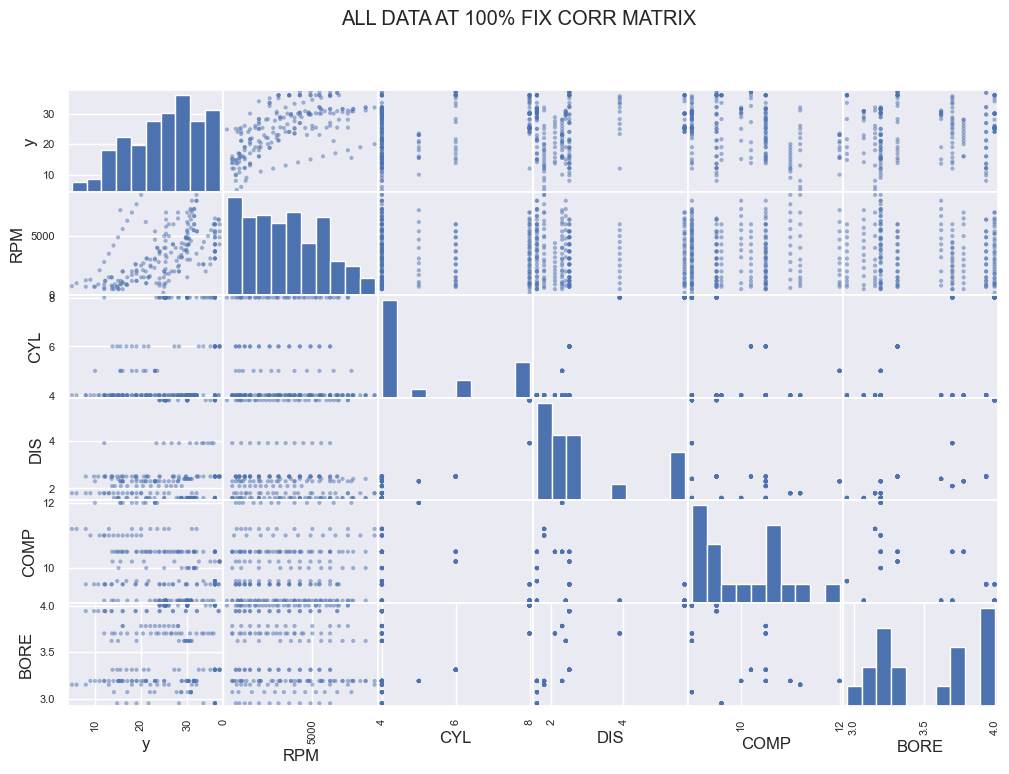

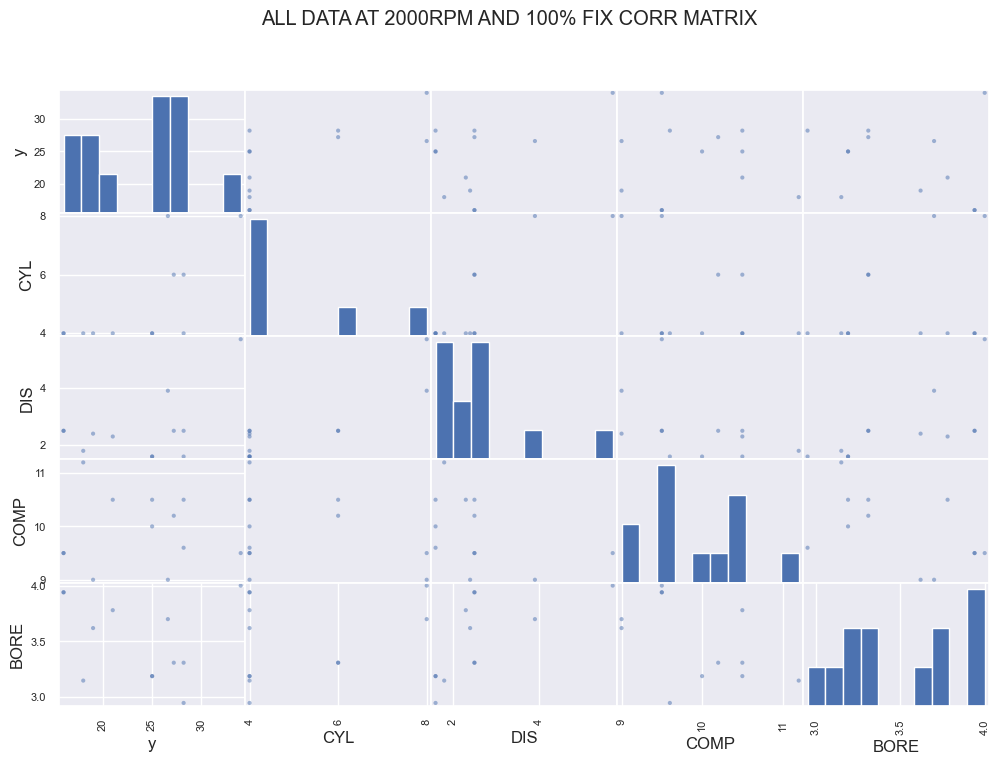

In [12]:
attributes = ["y", "RPM", "CYL","DIS","COMP","BORE", ]
scatter_matrix(per_100_data[attributes], figsize=(12, 8))
plt.suptitle('ALL DATA AT 100% FIX CORR MATRIX')             
plt.show()

attributes = ["y", "CYL","DIS","COMP","BORE"]
scatter_matrix(data_2000and100[attributes], figsize=(12, 8))
plt.suptitle('ALL DATA AT 2000RPM AND 100% FIX CORR MATRIX') 
plt.show()


In [13]:
"""per_100_data.plot(kind="scatter", x="DIS", y="y", alpha=0.1)
plt.show()

RPM_2000_data.plot(kind="scatter", x="DIS", y="y", alpha=0.1)
plt.show()

data_2000and100.plot(kind="scatter", x="DIS", y="y", alpha=0.1)
plt.show()"""

'per_100_data.plot(kind="scatter", x="DIS", y="y", alpha=0.1)\nplt.show()\n\nRPM_2000_data.plot(kind="scatter", x="DIS", y="y", alpha=0.1)\nplt.show()\n\ndata_2000and100.plot(kind="scatter", x="DIS", y="y", alpha=0.1)\nplt.show()'

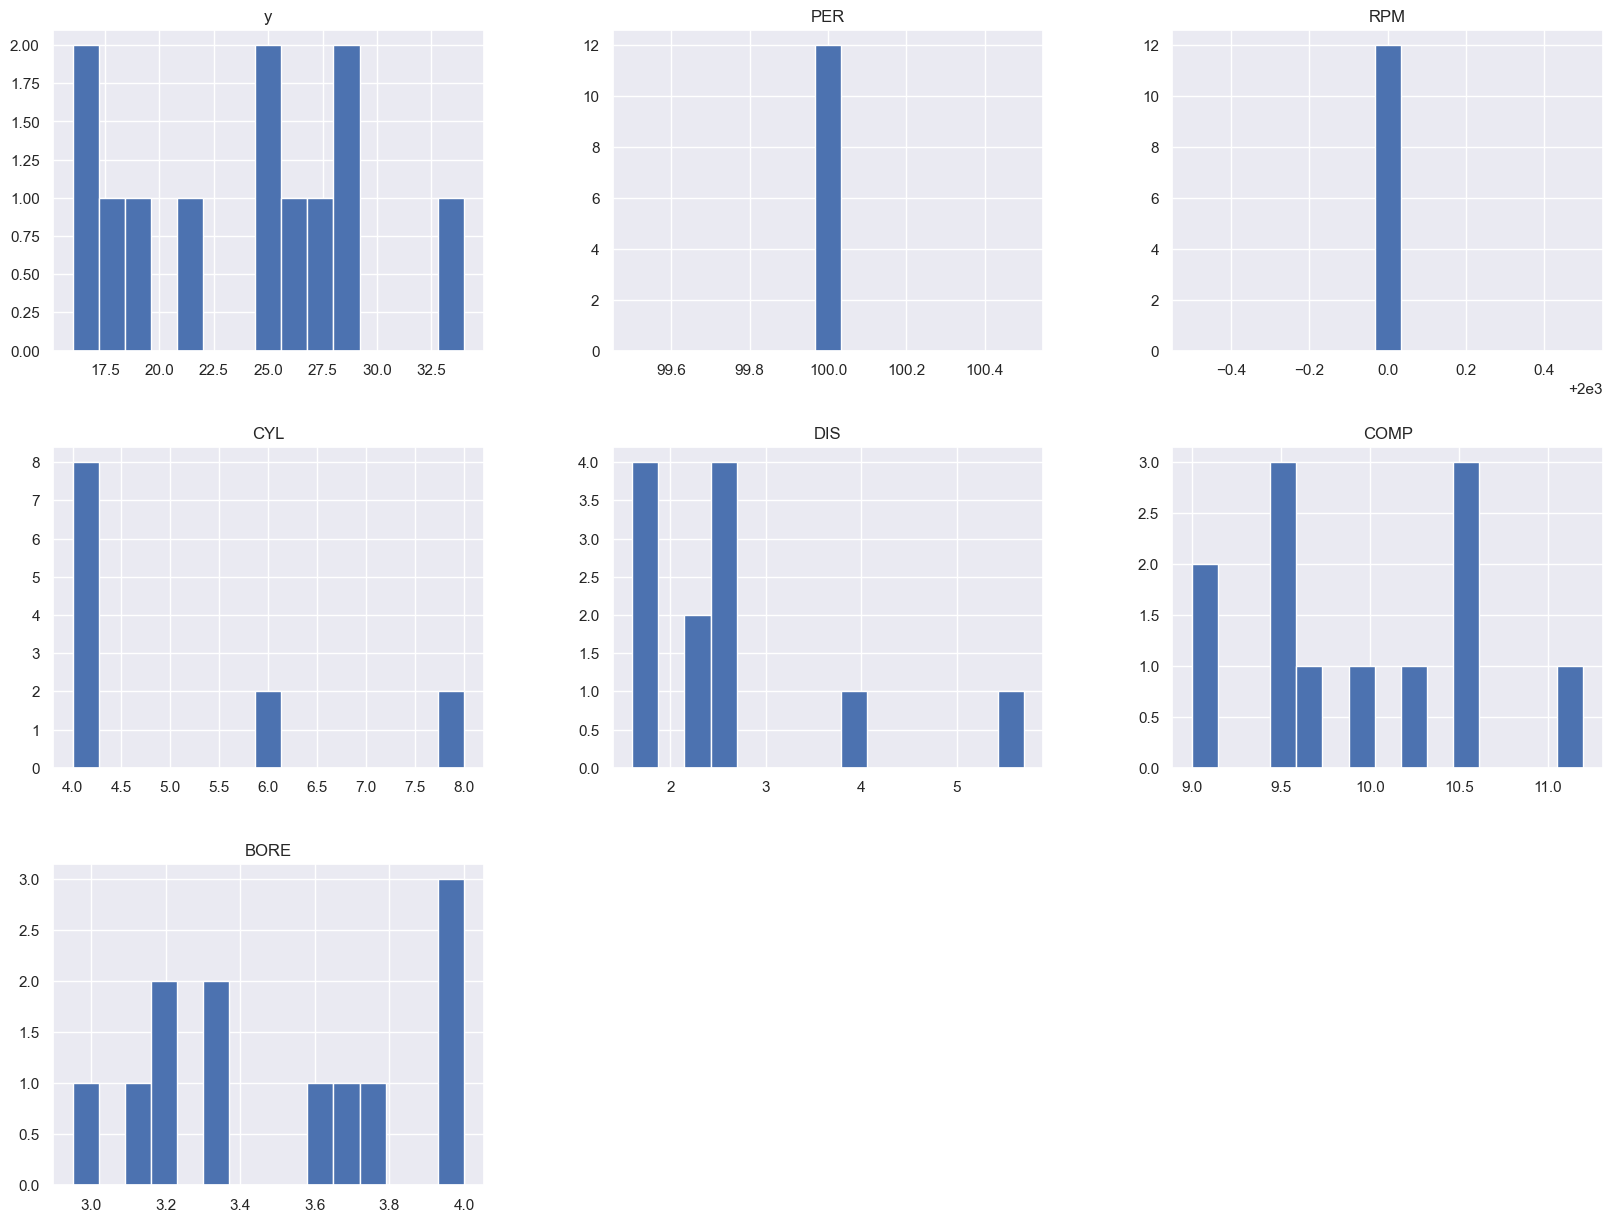

In [14]:
data_2000and100.hist(bins=15, figsize=(20,15))# show that data need to normalize, also shows a dimention problem with some x's
plt.show()

# PIPELINE

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
CYL_ix, DIS_ix = 2, 3 # see xdata.info or X_train.info for values

In [16]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, name="name"): 
        self.name = name# no *args or **kargs

    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X, y=None):
        Xnp =X.values
        dis_per_cyl = (Xnp[:, DIS_ix] / Xnp[:, CYL_ix]).reshape(-1, 1)  
        return np.hstack([Xnp, dis_per_cyl])

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [18]:
"""Now that we have looked at the data to understand if there is any problems with in the data for the most part there isnt
any problems, there isnt any thing that comes to mind for combine features lets sepate the data in x and y and then train val test"""
#Seperating y,x
y_Data = ["y"]
x_Data = ["RPM", "CYL","DIS","COMP","BORE", "PER"]

ydata = df.drop(x_Data, axis=1).values
xdata = df.drop(y_Data, axis=1)
# xdata.info() # index info for ADD feature 

print("\n xdata shape:\n",xdata.shape)
print("\n ydata shape:\n",ydata.size)

X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, shuffle=True, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1)
print("\nX_train shape:\n", X_train.shape)
print("\nX_test shape:\n", X_test.shape)
#print("\nX_val shape:\n", X_val.shape) #cross val small set so this will help
# X_train.info()

#missing data
"""there is no data missing at this time, might change if we need more data later"""
df_zeros = df[df.y == 0 ]
print('Zeros in y', df_zeros.shape)# the 2 points here are ment to be 0, if there were a large set at a small range of IDX then we would remove that set

#Cat features
"""all the X data may look like CAT but its not, there may need to be a engineer feature in the future i need to get some 
background info to know how to handle them

the other problem is the demality of the data y vary alot where many of theses x values do not, a coratation that may show
in the MLmodel is that at a given RPM the COMP is qubic this is an idea"""


#Feature engineering
"""if we want to engineer features in the future place code there  IE. class to call,see note in cat features"""

data_pipeline = Pipeline(steps = [('attribs_adder', CombinedAttributesAdder()),
                                 ('std_scaler', StandardScaler()) #add  Feature engineering hear later and missing data   
                                ])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.fit_transform(X_test)

print("xTrain",X_train_processed[0,:])
print("xTrainShape",X_train_processed.shape,"\n")
print("yTrainShape",y_train.shape)




 xdata shape:
 (3744, 6)

 ydata shape:
 3744

X_train shape:
 (2995, 6)

X_test shape:
 (749, 6)
Zeros in y (2, 7)
xTrain [-0.9422478   0.35311241  0.59840337 -0.11702486  0.35637317 -0.54751137
 -0.92983908]
xTrainShape (2995, 7) 

yTrainShape (2995, 1)


# DATA REVIEW

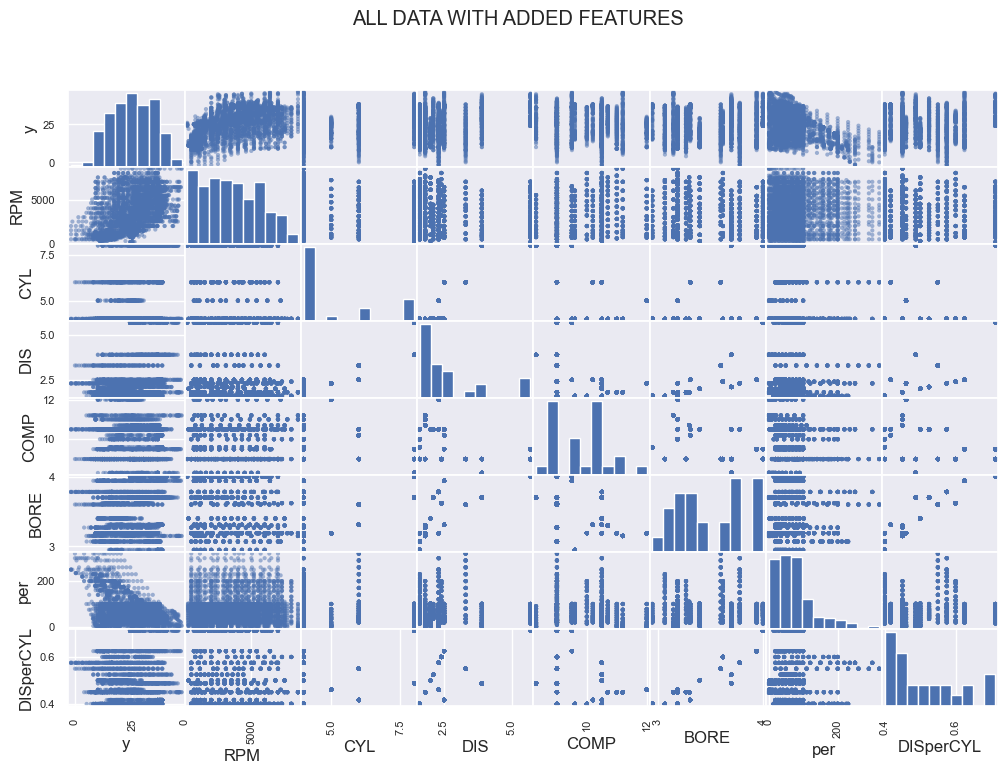

In [19]:
#combines raw data back together and adds DIS/CYL to view corr
DISCYL =CombinedAttributesAdder()
x_DISCYL = DISCYL.fit_transform(xdata)
y_X_DISCYL= np.hstack([ydata, x_DISCYL])
y_X_DISCYL = pd.DataFrame(y_X_DISCYL, columns=["y", "per","RPM","CYL","DIS","COMP","BORE", "DISperCYL"])
attributes = ["y", "RPM", "CYL","DIS","COMP","BORE", "per", "DISperCYL"]
scatter_matrix(y_X_DISCYL[attributes], figsize=(12, 8))
plt.suptitle('ALL DATA WITH ADDED FEATURES')
plt.show()



In [19]:
idx_100_PER = y_X_DISCYL.per[y_X_DISCYL.per == 100].index.tolist()
PER_100_data = y_X_DISCYL.loc[idx_100_PER]#all data with 100%
PER_corr = PER_100_data.corr()

idx_2000_rpm = y_X_DISCYL.RPM[y_X_DISCYL.RPM == 2000].index.tolist()
rpm_2000_data = y_X_DISCYL.loc[idx_2000_rpm] #all data with 2000rpm
rpm_corr = rpm_2000_data.corr()


idx_100and2000 = PER_100_data.RPM[PER_100_data.RPM == 2000].index.tolist()
data_100and2000 = y_X_DISCYL.loc[idx_100and2000] #all data with 2000rpm and 100%
BOTH_corr = data_100and2000.corr()


print("ALL DATA WITH ADDED FEATURES", "\n")
print("% Lock data", "\n")
print(PER_corr["y"].sort_values(ascending=False))
print("RPM Lock data", "\n")
print(rpm_corr["y"].sort_values(ascending=False), "\n")
print("both RPM and % lock data", "\n")
print(BOTH_corr["y"].sort_values(ascending=False))



ALL DATA WITH ADDED FEATURES 

% Lock data 

y            1.000000
RPM          0.601469
CYL          0.304958
DIS          0.224978
BORE         0.046628
DISperCYL    0.021738
COMP        -0.325496
per               NaN
Name: y, dtype: float64
RPM Lock data 

y            1.000000
CYL          0.637858
DIS          0.467998
BORE        -0.103380
DISperCYL   -0.163041
COMP        -0.265478
per         -0.446206
RPM               NaN
Name: y, dtype: float64 

both RPM and % lock data 

y            1.000000
CYL          0.695936
DIS          0.489523
COMP        -0.048812
DISperCYL   -0.220832
BORE        -0.228475
per               NaN
RPM               NaN
Name: y, dtype: float64


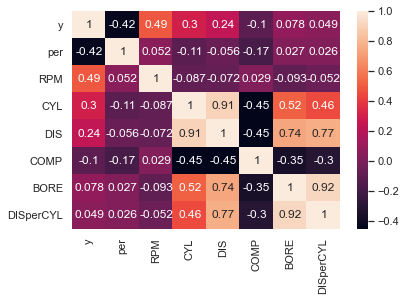

In [20]:
#corr heatmap FE
corr_matrix_FE = y_X_DISCYL.corr()
ax1 = sns.heatmap(corr_matrix_FE, annot=True)

# Model Selection

training the linear model
ridge done 

ridge poly done 

poly done 

tree done 

forest done 

['12.78%', '12.66%', '9.69%', '4.49%', '4.36%', '3.75%'] 



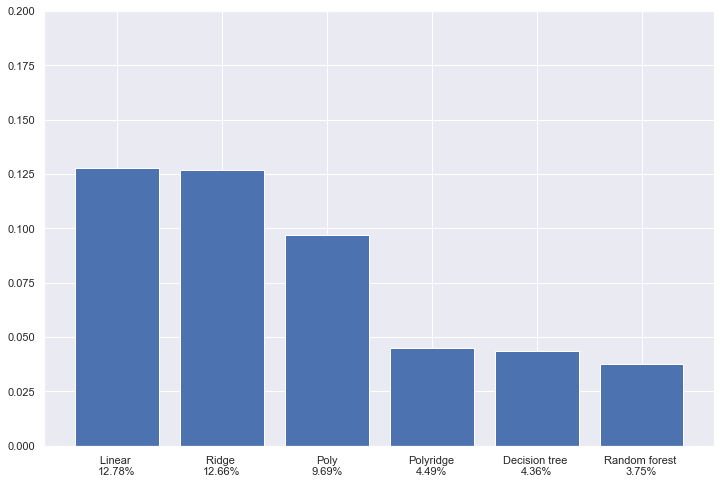


 model_selection = random forest


In [21]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

#model section
#basic models will need to pick one and refine

poly_features = PolynomialFeatures(degree=6, include_bias=False )
X_train_processed_poly = poly_features.fit_transform(X_train_processed)
target_range = y_train.max()-y_train.min();

poly_features2 = PolynomialFeatures(degree=2, include_bias=False )
X_train_processed_poly2 = poly_features2.fit_transform(X_train_processed)


#linear model
linear_reg = SGDRegressor(eta0=0.01, max_iter=1000, tol=0.01, random_state=1);
print("training the linear model")
linear_scores = cross_val_score(linear_reg, X_train_processed, y_train.squeeze(), scoring="neg_mean_squared_error", cv=10)

# all done in one line later
"""linear_rmse_scores = np.sqrt(-linear_scores)
average_cross_validation_Linear_RMSE = linear_rmse_scores.mean();
print("\nRMSE relative to range: {0:0.2%}".format(average_cross_validation_Linear_RMSE/target_range))
print('\n')
"""
ridge_reg_lin = Ridge(alpha=0.1, solver="cholesky", max_iter=1000, random_state=1)
ridge_scores_lin = cross_val_score(ridge_reg_lin, X_train_processed, y_train.squeeze(), scoring="neg_mean_squared_error", cv=10)
print("ridge done \n")

#ridge model
ridge_reg = Ridge(alpha=0.1, solver="cholesky", max_iter=1000, random_state=1)
ridge_scores = cross_val_score(ridge_reg, X_train_processed_poly, y_train.squeeze(), scoring="neg_mean_squared_error", cv=10)
print("ridge poly done \n")

#ploy regressor
ploy_scores = cross_val_score(linear_reg, X_train_processed_poly2, y_train.squeeze(), scoring="neg_mean_squared_error", cv=10)
print("poly done \n")

#decision tree
tree_reg = DecisionTreeRegressor(random_state=1)
tree_scores = cross_val_score(tree_reg, X_train_processed, y_train.squeeze(), scoring="neg_mean_squared_error", cv=10)
print("tree done \n")

#forest
forest_reg = RandomForestRegressor(n_estimators=10, random_state=1)
forest_scores = cross_val_score(forest_reg, X_train_processed, y_train.squeeze(), scoring="neg_mean_squared_error", cv=10)
print('forest done \n')

#RMSE relative to range
linear_average_RMSE = np.sqrt(-linear_scores).mean()/target_range;
R_linear_average_RMSE = np.sqrt(-ridge_scores_lin).mean()/target_range;
ploy_average_RMSE = np.sqrt(-ploy_scores).mean()/target_range;
ridge_average_RMSE = np.sqrt(-ridge_scores).mean()/target_range;
tree_average_RMSE = np.sqrt(-tree_scores).mean()/target_range;
forest_average_RMSE = np.sqrt(-forest_scores).mean()/target_range;

#plot of RMSE relative to range
x = [1, 2, 3, 4, 5, 6]
average_RMSEs = np.array([linear_average_RMSE,R_linear_average_RMSE, ploy_average_RMSE, ridge_average_RMSE, 
                          tree_average_RMSE, forest_average_RMSE])
RMSE = ['{:.2%}'.format(item) for item in average_RMSEs]
RMSE_array = np.array(RMSE)
model_names = ["Linear \n" + RMSE_array[0], "Ridge \n" + RMSE_array[1], "Poly\n" + RMSE_array[2], "Polyridge\n" + RMSE_array[3], "Decision tree \n" + RMSE_array[4], "Random forest \n"+RMSE_array[5]]

average_RMSEs = np.array([linear_average_RMSE,R_linear_average_RMSE, ploy_average_RMSE, ridge_average_RMSE, 
                          tree_average_RMSE, forest_average_RMSE])
print(['{:.2%}'.format(item) for item in average_RMSEs], "\n")

plt.figure(figsize=(12,8),)
plt.bar(x, average_RMSEs)
plt.xticks(x, model_names)
plt.ylim(top=.2)
plt.show()
print("\n model_selection = random forest")

# Random Forest

In [22]:
from sklearn.model_selection import GridSearchCV
model =  RandomForestRegressor()
param_grid = [
                {'max_depth': [ 50,100, 300],
                 'n_estimators': [500,1000, 2000], 
                 
                 #'max_features' :['auto', 'sqrt', 'log2']
                } 
]

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', refit=True)
grid_search.fit(X_train_processed, y_train.squeeze())
print(grid_search.best_params_)

{'max_depth': 50, 'n_estimators': 1000}


In [23]:
best_regressor_model = grid_search.best_estimator_
best_forest_scores = cross_val_score(best_regressor_model, X_train_processed, 
                                     y_train.squeeze(), scoring="neg_mean_squared_error", cv=10)
best_forest_average_RMSE = np.sqrt(-best_forest_scores).mean()/target_range;
print('{:.2%}'.format(best_forest_average_RMSE))


3.52%


In [24]:
from sklearn.metrics import mean_squared_error, r2_score
final_predictions_rf = best_regressor_model.predict(X_test_processed)
final_mse_rf = mean_squared_error(y_test, final_predictions_rf)
final_rmse_rf = np.sqrt(final_mse_rf)/target_range
print("RMSE random forest","{0:.2%}".format(final_rmse_rf))


RMSE random forest 4.52%


In [25]:
Rtest_score = r2_score(y_test, final_predictions_rf)

print("random forest R^2 value", Rtest_score)

random forest R^2 value 0.9447285267253022


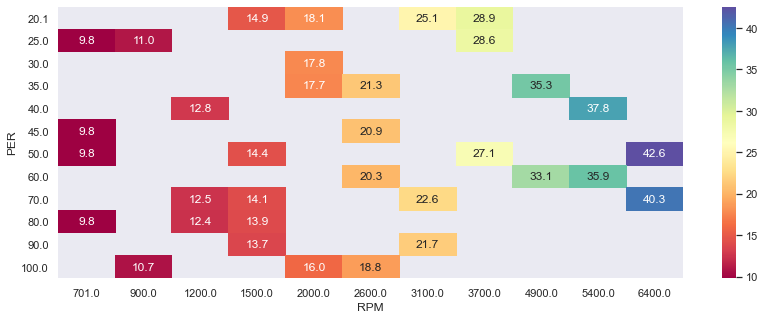

In [41]:
#reshape H, Y, X, test values and reindex to the ID of data not split data
Hdx =np.reshape(final_predictions_rf[1:],(1,-1))
hdx =Hdx.flatten()
ydx = np.reshape(y_test[1:],(1,-1))
ydx1 = ydx.flatten()
idx= X_test[1:].index.values
xval1 = X_test[1:].drop(["PER","CYL","DIS","COMP","BORE"], axis=1).values.flatten()
xval2 = X_test[1:].drop(["RPM","CYL","DIS","COMP","BORE"], axis=1).values.flatten()

IDX_test = np.vstack([idx,ydx1, hdx, xval1,xval2])
IDX_test = IDX_test.transpose()

RF = pd.DataFrame(IDX_test, columns=["ID", "Y","H","RPM","PER"])
RF = RF.sort_values(by=['ID'],ignore_index=True)

RF=RF[0:34]
YRF = RF.drop(["ID","H"], axis=1)
HRF = RF.drop(["ID","Y"], axis=1)

pivottedy = YRF.pivot_table(index='PER', columns='RPM', values='Y')
pivottedh = HRF.pivot_table(index='PER', columns='RPM', values='H')

plt.figure(figsize=(14, 5))
ax1 = sns.heatmap(pivottedy, annot=True, cmap="Spectral",fmt=".1f")
plt.yticks(rotation=0) 

RF1= RF.copy()
Y_test = RF1.drop(["ID","H","RPM","PER"], axis=1).values.flatten()
H_test = RF1.drop(["ID", "Y","RPM","PER"], axis=1).values.flatten()
#print(Y_test)
#print(H_test.shape)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '20.1'),
  Text(0, 1.5, '25.0'),
  Text(0, 2.5, '30.0'),
  Text(0, 3.5, '35.0'),
  Text(0, 4.5, '40.0'),
  Text(0, 5.5, '45.0'),
  Text(0, 6.5, '50.0'),
  Text(0, 7.5, '60.0'),
  Text(0, 8.5, '70.0'),
  Text(0, 9.5, '80.0'),
  Text(0, 10.5, '90.0'),
  Text(0, 11.5, '100.0')])

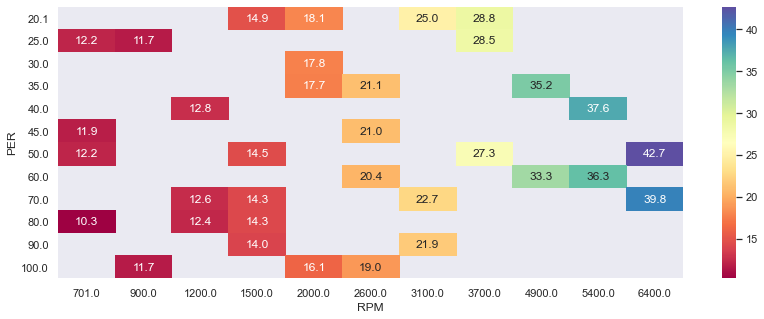

In [47]:
plt.figure(figsize=(14, 5))
ax2 = sns.heatmap(pivottedh, annot=True, cmap="Spectral",fmt=".1f")
plt.yticks(rotation=0) 


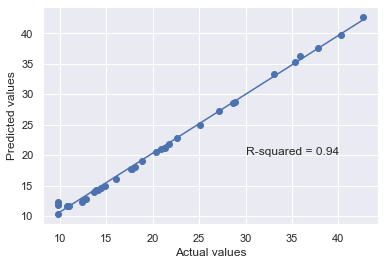

In [48]:
r_squared = Rtest_score
plt.scatter(Y_test,H_test)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, H_test, 1))(np.unique(Y_test)))

plt.text(30, 20, 'R-squared = %0.2f' % r_squared)
plt.show()

# Shallow Neural Network 

In [52]:
from keras import regularizers
K.clear_session()
n_hidden1 = 120
n_hidden2 = 15
n_outputs = 1

learning_rate = 0.01
num_epochs = 150

def build_model(n):
    model_SNN = Sequential()
    model_SNN.add(Dense(n_hidden1, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.0001) ))
    model_SNN.add(Dense(n_hidden2, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    model_SNN.add(Dense(n_outputs, activation='linear',kernel_regularizer=tf.keras.regularizers.l2(0.0001)))

    opt = optimizers.Nadam(lr=learning_rate)
    model_SNN.compile(optimizer= opt,
              loss='mean_squared_error',
              metrics=['mse', 'mae', 'mape', 'cosine'])
    return model_SNN

    
"""model_SNN = Sequential()

model_SNN.add(Dense(n_hidden1, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_SNN.add(Dense(n_hidden2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_SNN.add(Dense(n_outputs, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

opt = optimizers.Nadam(lr=learning_rate)
model_SNN.compile(optimizer= opt,
              loss='mean_squared_error',
              metrics=['mse', 'mae', 'mape', 'cosine'])"""


"model_SNN = Sequential()\n\nmodel_SNN.add(Dense(n_hidden1, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)))\nmodel_SNN.add(Dense(n_hidden2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)))\nmodel_SNN.add(Dense(n_outputs, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.001)))\n\nopt = optimizers.Nadam(lr=learning_rate)\nmodel_SNN.compile(optimizer= opt,\n              loss='mean_squared_error',\n              metrics=['mse', 'mae', 'mape', 'cosine'])"

In [53]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 3)                         

cv_loss_scores = []

fold_no = 1
for train, validation in kf.split(X_train_processed, y_train):
    model_SNN = build_model(X_train_processed.shape[1])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model_SNN.fit(X_train_processed[train], 
                        y_train[train],
                        epochs=num_epochs,
                        batch_size=40,
                        verbose = 1)
    
    scores = model_SNN.evaluate(X_train_processed[validation], y_train[validation], verbose=1)
    print (scores)
    print('fold {0}: Loss:{1:0.2%}'.format(fold_no, scores[0]))
    cv_loss_scores.append(scores[0])
    fold_no +=1

print('\n--------------------------------DONE------------------------------------\n')
print("CV loss values for each fold:\n", cv_loss_scores)

print("\nAverage CV loss: {0:0.2%}".format(np.array(cv_loss_scores).mean()))


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
1996/1996 [==============================] - 1s 306us/step - loss: 162.6649 - mse: 162.6556 - mae: 9.3738 - mape: 2920806.5000 - cosine: 0.9315
Epoch 2/150
1996/1996 [==============================] - 0s 61us/step - loss: 29.3736 - mse: 29.3615 - mae: 4.1651 - mape: 3472246.5000 - cosine: 0.9955
Epoch 3/150
1996/1996 [==============================] - 0s 64us/step - loss: 23.0878 - mse: 23.0746 - mae: 3.6721 - mape: 3052031.2500 - cosine: 0.9955
Epoch 4/150
1996/1996 [==============================] - 0s 57us/step - loss: 20.3685 - mse: 20.3540 - mae: 3.3977 - mape: 2330630.2500 - cosine: 0.9955
Epoch 5/150
1996/1996 [==============================] - ETA: 0s - loss: 17.6559 - mse: 17.6406 - mae: 3.1386 - mape: 3552499.5000 - cosine: 0.995 - 0s 36us/step - loss: 18.5450 - mse: 18.5296 - mae: 3.2325 - mape: 2776507.2500 - cosine: 0.9955
Epoch 6/150
1996/1996 [====================

In [54]:
best_snn_average_RMSE_N = np.sqrt(np.array(cv_loss_scores)).mean()/target_range;
print('{:.2%}'.format(best_snn_average_RMSE_N))
print(target_range)
print(cv_loss_scores)

5.00%
48.2
[6.3029256525698365, 5.565040451252389, 5.605117497797719]


In [55]:
final_predictions_snn = model_SNN.predict(X_test_processed)


In [56]:
final_mse_snn = mean_squared_error(y_test, final_predictions_snn)
final_rmse_snn = np.sqrt(final_mse_snn)/target_range
print("{0:.2%}".format(final_rmse_snn))
print("{0:.2%}".format(final_mse_snn))

5.13%
610.78%


In [57]:
#reshape H, Y, X, test values and reindex to the ID of data not split data

Hdx_snn =np.reshape(final_predictions_snn[1:],(1,-1))
hdx_snn =Hdx_snn.flatten()
ydx_snn = np.reshape(y_test[1:],(1,-1))
ydx1_snn = ydx.flatten()
idx_snn = X_test[1:].index.values#reshape(-1,1)
xval1_snn = X_test[1:].drop(["PER","CYL","DIS","COMP","BORE"], axis=1).values.flatten()
xval2_snn = X_test[1:].drop(["RPM","CYL","DIS","COMP","BORE"], axis=1).values.flatten()
IDX_test_snn = np.vstack([idx_snn,ydx1_snn, hdx_snn, xval1_snn,xval2_snn])
IDX_test_snn = IDX_test_snn.transpose()
SNN = pd.DataFrame(IDX_test_snn, columns=["ID", "Y","H","RPM","PER"])
SNN = SNN.sort_values(by=['ID'],ignore_index=True)
#print(SNN[0:34])



[14.9 18.1 25.1 28.9  9.8 11.  28.6 17.8 17.7 21.3 35.3 12.8 37.8  9.8
 20.9  9.8 14.4 27.1 42.6 20.3 33.1 35.9 12.5 14.1 22.6 40.3  9.8 12.4
 13.9 13.7 21.7 10.7 16.  18.8]
(34,)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '20.1'),
  Text(0, 1.5, '25.0'),
  Text(0, 2.5, '30.0'),
  Text(0, 3.5, '35.0'),
  Text(0, 4.5, '40.0'),
  Text(0, 5.5, '45.0'),
  Text(0, 6.5, '50.0'),
  Text(0, 7.5, '60.0'),
  Text(0, 8.5, '70.0'),
  Text(0, 9.5, '80.0'),
  Text(0, 10.5, '90.0'),
  Text(0, 11.5, '100.0')])

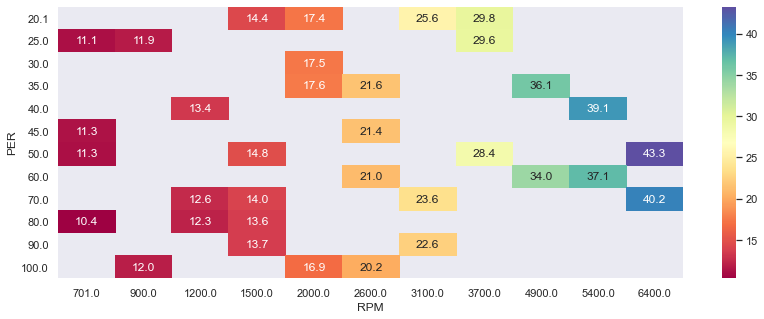

In [58]:
# SNN Heatmap H_values
SNN1=SNN[0:34]
HSNN = SNN1.drop(["ID","Y"], axis=1)
pivottedh_snn = HSNN.pivot_table(index='PER', columns='RPM', values='H')

SNN2 = SNN1.copy()
Y_test_snn = SNN2.drop(["ID","H","RPM","PER"], axis=1).values.flatten()
H_test_snn = SNN2.drop(["ID", "Y","RPM","PER"], axis=1).values.flatten()
print(Y_test_snn)
print(H_test_snn.shape)

plt.figure(figsize=(14, 5))
ax2_SNN = sns.heatmap(pivottedh_snn, annot=True, cmap="Spectral", fmt=".1f")
plt.yticks(rotation=0) 

R^2 value 0.9287531558432867


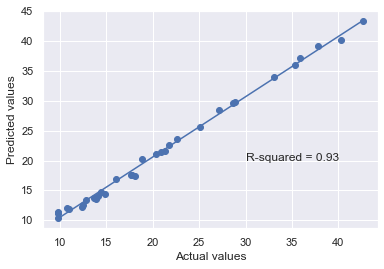

In [59]:
# SNN R^2 plot

r_squared_snn = r2_score(y_test, final_predictions_snn)
r_squared_snn = r_squared_snn
print("R^2 value", r_squared_snn)
plt.scatter(Y_test,H_test_snn)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, H_test_snn, 1))(np.unique(Y_test)))
plt.text(30, 20, 'R-squared = %0.2f' % r_squared_snn)
plt.show()

In [60]:
"""
# non Kfold SNN
K.clear_session()
model_SNN2 = Sequential()

model_SNN2.add(Dense(n_hidden1, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_SNN2.add(Dense(n_hidden2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_SNN2.add(Dense(n_outputs, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))

opt = optimizers.adam(lr=learning_rate)
model_SNN2.compile(optimizer= opt,
              loss='mean_squared_error',
              metrics=['mse', 'mae', 'mape', 'cosine',])"""

"\n# non Kfold SNN\nK.clear_session()\nmodel_SNN2 = Sequential()\n\nmodel_SNN2.add(Dense(n_hidden1, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))\nmodel_SNN2.add(Dense(n_hidden2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))\nmodel_SNN2.add(Dense(n_outputs, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))\n\nopt = optimizers.adam(lr=learning_rate)\nmodel_SNN2.compile(optimizer= opt,\n              loss='mean_squared_error',\n              metrics=['mse', 'mae', 'mape', 'cosine',])"

In [61]:
#non kfold SNN fit
"""K.clear_session()
historySNN2 = model_SNN2.fit(X_train_processed,
                    y_train,
                    epochs= num_epochs,
                    batch_size=25,
                    verbose = 1,
                    validation_split = 0.1)"""


'K.clear_session()\nhistorySNN2 = model_SNN2.fit(X_train_processed,\n                    y_train,\n                    epochs= num_epochs,\n                    batch_size=25,\n                    verbose = 1,\n                    validation_split = 0.1)'

In [62]:
#plots
"""loss = historySNN2.history['loss']
val_loss = historySNN2.history['val_loss']

mae = historySNN2.history['mae']
val_mae = historySNN2.history['val_mae']

mse = historySNN2.history['mse']
val_mse = historySNN2.history['val_mse']
"""


"loss = historySNN2.history['loss']\nval_loss = historySNN2.history['val_loss']\n\nmae = historySNN2.history['mae']\nval_mae = historySNN2.history['val_mae']\n\nmse = historySNN2.history['mse']\nval_mse = historySNN2.history['val_mse']\n"

# Deep Neural Networks - DNN

In [63]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout


In [64]:

K.clear_session()

#init = keras.initializers.RandomUniform(minval=0, maxval=1, seed=1)


dropout_rate = 0.05 

model_dnn = Sequential()

model_dnn.add(Dense(1000, kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_dnn.add(BatchNormalization())
model_dnn.add(Dropout(dropout_rate))
model_dnn.add(Activation('relu'))
model_dnn.add(Dense(500))
model_dnn.add(BatchNormalization())
model_dnn.add(Dropout(dropout_rate))
model_dnn.add(Activation('relu'))
model_dnn.add(Dense(300))
model_dnn.add(BatchNormalization())
model_dnn.add(Dropout(dropout_rate))
model_dnn.add(Activation('relu'))
model_dnn.add(Dense(150))
model_dnn.add(BatchNormalization())
model_dnn.add(Dropout(dropout_rate))
model_dnn.add(Activation('relu'))
model_dnn.add(Dense(50))
model_dnn.add(BatchNormalization())
model_dnn.add(Dropout(dropout_rate))
model_dnn.add(Activation('relu'))
model_dnn.add(Dense(20))
model_dnn.add(BatchNormalization())
model_dnn.add(Dropout(dropout_rate))
model_dnn.add(Activation('relu'))
model_dnn.add(Dense(5))
model_dnn.add(BatchNormalization())
model_dnn.add(Dropout(dropout_rate))
model_dnn.add(Activation('relu'))
model_dnn.add(Dense(1))

opt = keras.optimizers.adam(learning_rate=0.01)
model_dnn.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', 'mape', 'cosine'])

historyDNN = model_dnn.fit(X_train_processed, y_train, validation_split = 0.1, epochs=200, verbose=1)




Train on 2695 samples, validate on 300 samples
Epoch 1/200
2695/2695 [==============================] - 5s 2ms/step - loss: 583.1313 - mae: 22.7267 - mape: 844999.8750 - cosine: 0.8527 - val_loss: 162.2404 - val_mae: 11.7083 - val_mape: 52.3901 - val_cosine: 0.9000
Epoch 2/200
2695/2695 [==============================] - 3s 1ms/step - loss: 190.0318 - mae: 11.8424 - mape: 399019.4688 - cosine: 0.9959 - val_loss: 112.4756 - val_mae: 8.7578 - val_mape: 41.6185 - val_cosine: 1.0000.8111 - mae: 12.8140 - mape: 480064.2812 - cosine:
Epoch 3/200
2695/2695 [==============================] - 3s 975us/step - loss: 43.9826 - mae: 5.0821 - mape: 2790286.0000 - cosine: 0.9959 - val_loss: 117.9285 - val_mae: 9.6386 - val_mape: 45.5399 - val_cosine: 1.0000
Epoch 4/200
2695/2695 [==============================] - 3s 1ms/step - loss: 41.6028 - mae: 4.8703 - mape: 2450919.7500 - cosine: 0.9959 - val_loss: 43.4060 - val_mae: 5.4899 - val_mape: 24.8309 - val_cosine: 1.00009571 - mape: 6070946 - ETA: 1s -

In [65]:
final_predictions_dnn = model_dnn.predict(X_test_processed)

In [66]:
final_mse_dnn = mean_squared_error(y_test, final_predictions_dnn)
final_rmse_dnn = np.sqrt(final_mse_dnn)/target_range
print("{0:.2%}".format(final_rmse_dnn))
print("{0:.2%}".format(final_mse_dnn))

5.27%
645.49%


In [67]:
#reshape H, Y, X, test values and reindex to the ID of data not split data

Hdx_dnn =np.reshape(final_predictions_dnn[1:],(1,-1))
hdx_dnn =Hdx_dnn.flatten()
ydx_dnn = np.reshape(y_test[1:],(1,-1))
ydx1_dnn = ydx.flatten()
idx_dnn = X_test[1:].index.values#reshape(-1,1)
xval1_dnn = X_test[1:].drop(["PER","CYL","DIS","COMP","BORE"], axis=1).values.flatten()
xval2_dnn = X_test[1:].drop(["RPM","CYL","DIS","COMP","BORE"], axis=1).values.flatten()
IDX_test_dnn = np.vstack([idx_dnn,ydx1_dnn, hdx_dnn, xval1_dnn,xval2_dnn])
IDX_test_dnn = IDX_test_dnn.transpose()
DNN = pd.DataFrame(IDX_test_dnn, columns=["ID", "Y","H","RPM","PER"])
DNN = DNN.sort_values(by=['ID'],ignore_index=True)
#print(DNN[0:34])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '20.1'),
  Text(0, 1.5, '25.0'),
  Text(0, 2.5, '30.0'),
  Text(0, 3.5, '35.0'),
  Text(0, 4.5, '40.0'),
  Text(0, 5.5, '45.0'),
  Text(0, 6.5, '50.0'),
  Text(0, 7.5, '60.0'),
  Text(0, 8.5, '70.0'),
  Text(0, 9.5, '80.0'),
  Text(0, 10.5, '90.0'),
  Text(0, 11.5, '100.0')])

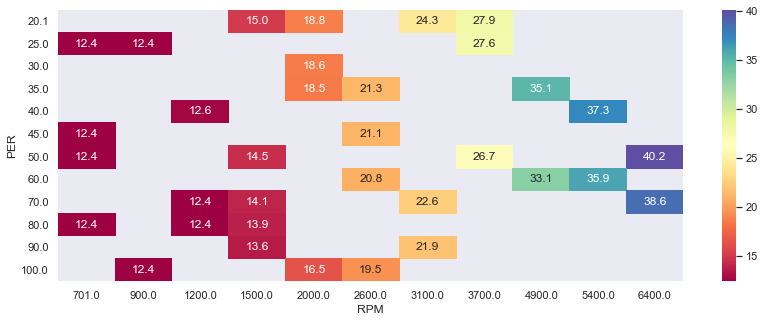

In [69]:
# DNN Heatmap H_values
DNN1 = DNN[0:34]
HDNN = DNN1.drop(["ID","Y"], axis=1)
pivottedh_dnn = HDNN.pivot_table(index='PER', columns='RPM', values='H')

DNN2 = DNN1.copy()
Y_test_dnn = DNN2.drop(["ID","H","RPM","PER"], axis=1).values.flatten()
H_test_dnn = DNN2.drop(["ID", "Y","RPM","PER"], axis=1).values.flatten()
#print(Y_test_dnn)
#print(H_test_dnn.shape)
plt.figure(figsize=(14, 5))
ax2_DNN = sns.heatmap(pivottedh_dnn, annot=True, cmap="Spectral",fmt=".1f")
plt.yticks(rotation=0) 

R^2 value 0.9247043640726963


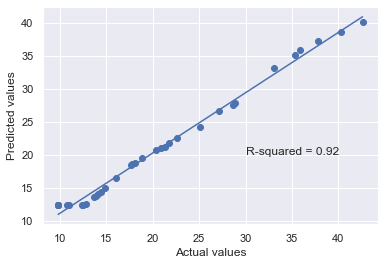

In [70]:
# DNN R^2 plot

r_squared_dnn = r2_score(y_test, final_predictions_dnn)
r_squared_dnn = r_squared_dnn
print("R^2 value", r_squared_dnn)
plt.scatter(Y_test,H_test_dnn)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, H_test_dnn, 1))(np.unique(Y_test)))
plt.text(30, 20, 'R-squared = %0.2f' % r_squared_dnn)
plt.show()